In [14]:
from Bio.SeqUtils.ProtParam import ProteinAnalysis
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import plot_roc_curve, log_loss, f1_score, fbeta_score, recall_score, precision_score, confusion_matrix
# from sklearn.metrics import log_loss, f1_score, fbeta_score, recall_score, precision_score, confusion_matrix
import urllib.request, json
from skimage.filters import threshold_otsu
from pprint import pprint
from sklearn.model_selection import StratifiedKFold, KFold, StratifiedShuffleSplit
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import *

# Homemade functions required
from data_prep_functions import *
from interpro_scraping import interpro_scraping_pandas

In [3]:
############# EDIT, FILL IN DATA HERE ############
data_file = '2020-02-03 MS compiled for ML project.xlsx'  # needs xlsx at the end 

plasma_prop_sheet = 'Protein properties, plasma'
plasma_mass_spec_sheet = '(GT)15-SWCNT, plasma'

csf_prop_sheet = 'Protein properties, CSF'
csf_mass_spec_sheet = '(GT)15-SWCNT, CSF'
###################################################
############ NO EDITS REQUIRED ##############
data_filepath = "data/"+data_file
# load data

plasma_raw_data = pd.read_excel(data_filepath, sheet_name= plasma_prop_sheet, thousands=',')
csf_raw_data = pd.read_excel(data_filepath, sheet_name= csf_prop_sheet, thousands=',')

plasma_mass_spec_data = pd.read_excel(data_filepath, sheet_name=plasma_mass_spec_sheet, header=2, thousands=',')
csf_mass_spec_data = pd.read_excel(data_filepath, sheet_name=csf_mass_spec_sheet, header=2, thousands=',')

# clean up data 

plasma_cleaned_data = clean_up_data_biopy(plasma_raw_data)
csf_cleaned_data = clean_up_data_biopy(csf_raw_data)


plasma_cleaned_data, csf_cleaned_data = normalize_mass_length(plasma_cleaned_data, csf_cleaned_data)

netsurfp_data = pd.read_excel("data/"+'netsurfp_2_lcms_proteins_processed.xlsx')

plasma_complete_data = pd.merge(plasma_cleaned_data, netsurfp_data, left_on='Entry', right_on='entry')
csf_complete_data = pd.merge(csf_cleaned_data, netsurfp_data, left_on='Entry', right_on='entry')

for df in [plasma_complete_data, csf_complete_data]:
    for col in ['asa_sum']:
        df[col+'_normalized'] = df[col] / df['Mass']

In [11]:
trials = 100
first_frame = True
correctness_frame = pd.DataFrame()
metrics_frame = pd.DataFrame()

for thresh_power in np.arange(1,3.6,.25):
    print('Power ', thresh_power)
    fluids_type_list=['plasma', 'csf']
    plasma_labels = plasma_mass_spec_data[['Accession', 'NP average','NP fold change']].copy()
    csf_labels = csf_mass_spec_data[['Accession', 'NP average', 'NP fold change']].copy()
    data_sheets = [plasma_labels, csf_labels]
    x = np.arange(0,1,.01)
    for k in range(2):
        sheet = data_sheets[k]
        fluid_type = fluids_type_list[k]

        print(f'\n{fluid_type.capitalize()} running')

        num_proteins = np.zeros(100)
        for i in np.arange(0,100,1):
            thresh = i/100
            index = (sheet['NP average']>thresh)
            num_proteins[i] = (np.count_nonzero(index))


        num_proteins_above_1_abundance = min(num_proteins)
        biexponent_dist = num_proteins - num_proteins_above_1_abundance
        num_protein_thresh = np.max(biexponent_dist)/pow(np.e,thresh_power)
        cutoff_thresh_value = min(x[(biexponent_dist<num_protein_thresh)&(biexponent_dist>0)], default=0)
        sheet['Corona'] = ((sheet['NP average']>cutoff_thresh_value) | (sheet['NP fold change']>1)).astype(int)
        print(sheet['Corona'].sum()/sheet['Corona'].shape[0])
    plasma_labels = plasma_labels.drop(['NP average', 'NP fold change'], axis=1)
    csf_labels = csf_labels.drop(['NP average', 'NP fold change'], axis=1)



    # checks for any accession lists
    plasma_labels = accession_expansion(plasma_labels) 
    csf_labels = accession_expansion(csf_labels)

    plasma_total_data_names = pd.merge(plasma_labels, plasma_complete_data.copy(), left_on='Accession', right_on='Entry')
    csf_total_data_names = pd.merge(csf_labels, csf_complete_data.copy(), left_on='Accession', right_on='Entry')

    plasma_total_data_names =plasma_total_data_names.drop(['Accession','Entry', 'entry', 'Sequence', 'Length', 'Mass'], axis=1)
    csf_total_data_names = csf_total_data_names.drop(['Accession','Entry', 'entry', 'Sequence', 'Length', 'Mass'], axis=1)

    features_plasma = plasma_total_data_names.copy()
    features_plasma = features_plasma.drop(['Corona'], axis=1)
    names_plasma = plasma_total_data_names['Corona'].copy()

    features_csf = csf_total_data_names.copy()
    features_csf = features_csf.drop(['Corona'], axis=1) 
    names_csf = csf_total_data_names['Corona'].copy()

    ### create a merged set
    features_plasma_labeled = features_plasma.copy()
    features_csf_labeled = features_csf.copy()

    features_plasma_labeled['phase_plasma'] = 1
    features_csf_labeled['phase_plasma'] = 0

    features_merged = features_plasma_labeled.append(features_csf_labeled, ignore_index=True)
    names_merged = names_plasma.append(names_csf, ignore_index=True)

    # set with no phase labeling names are identical to names merged
    features_merged_naive = features_merged.drop(['phase_plasma'], axis=1)
    
    scaler = MinMaxScaler()

    total_data = features_merged_naive.copy()
    total_data = total_data.fillna(0)
    total_data = total_data.drop(['Protein names'], axis=1)
    scaler = scaler.fit(total_data)
    scaled_df = pd.DataFrame(scaler.transform(total_data), columns=total_data.columns)

    names = names_merged.copy()
    
#     scaler = MinMaxScaler()

#     total_data = features_merged_naive.copy()
#     total_data = total_data.fillna(0)
#     total_data = total_data.drop(['Protein names'], axis=1)
#     scaler = scaler.fit(total_data)
#     scaled_df = pd.DataFrame(scaler.transform(total_data), columns=total_data.columns)


    df = scaled_df.copy()
    labels = names
    feature_imp = pd.DataFrame(columns=list(scaled_df.columns))

    i = 0
    sss = StratifiedShuffleSplit(n_splits=trials, test_size=0.1, random_state=2020)
    for train_index, test_index in sss.split(df, labels):
        X_train = df.iloc[train_index]
        X_test = df.iloc[test_index]
        y_train = labels.iloc[train_index]
        y_test = labels.iloc[test_index]
        k = i
        sme = SMOTE(sampling_strategy=.75, random_state=i, n_jobs=-1, k_neighbors=7)
        X_train_oversampled, y_train_oversampled = sme.fit_resample(X_train, y_train)

        # Create and Train
        rfc=RandomForestClassifier(criterion='entropy', n_jobs=-1, random_state=i, n_estimators=1000)
        #, , warm_start=False, min_samples_split=4, min_samples_leaf=2, max_features= 'log2', max_depth = 10)

        rfc.fit(X_train_oversampled,y_train_oversampled)
        if first_frame:  # Initialize 
            first_frame = False  # Don't Come back Here

            datadict = {'true':y_test.to_numpy(), 'estimate':rfc.predict(X_test), 'probability':rfc.predict_proba(X_test)[:, 1]}

            correctness_frame = pd.DataFrame(data=datadict)
            correctness_frame['round'] = i

            metrics_dict = {'AUC':metrics.roc_auc_score(y_test, rfc.predict_proba(X_test)[:, 1]),
            'Accuracy':rfc.score(X_test, y_test), 'Recall':recall_score(y_test, rfc.predict(X_test)), 
            'Precision':precision_score(y_test, rfc.predict(X_test)), 'F1':f1_score(y_test, rfc.predict(X_test))}

            metrics_frame = pd.DataFrame.from_dict(data=metrics_dict,orient='index').transpose()
            metrics_frame['round'] = i
            metrics_frame['Threshold Power'] = thresh_power


        else:
            datadict = {'true':y_test.to_numpy(), 'estimate':rfc.predict(X_test), 'probability':rfc.predict_proba(X_test)[:, 1]}
            revolve_frame = pd.DataFrame(data=datadict)
            revolve_frame['round'] = i
            correctness_frame = correctness_frame.append(revolve_frame, ignore_index=True)

            metrics_dict = {'AUC':metrics.roc_auc_score(y_test, rfc.predict_proba(X_test)[:, 1]),
            'Accuracy':rfc.score(X_test, y_test), 'Recall':recall_score(y_test, rfc.predict(X_test)), 
            'Precision':precision_score(y_test, rfc.predict(X_test)), 'F1':f1_score(y_test, rfc.predict(X_test))}
            metrics_revolve_frame = pd.DataFrame.from_dict(data=metrics_dict, orient='index').transpose()
            metrics_revolve_frame['round'] = i
            metrics_revolve_frame['Threshold Power'] = thresh_power
            
            metrics_frame = metrics_frame.append(metrics_revolve_frame, ignore_index=True)
    

        i += 1


        feature_imp.loc[i] = pd.Series(rfc.feature_importances_,index=list(df.columns))



        

Power  1.0

Plasma running
0.39285714285714285

Csf running
0.4032258064516129
Power  1.25

Plasma running
0.375

Csf running
0.3870967741935484
Power  1.5

Plasma running
0.3482142857142857

Csf running
0.3870967741935484
Power  1.75

Plasma running
0.33035714285714285

Csf running
0.3709677419354839
Power  2.0

Plasma running
0.3125

Csf running
0.3709677419354839
Power  2.25

Plasma running
0.29464285714285715

Csf running
0.3709677419354839
Power  2.5

Plasma running
0.2857142857142857

Csf running
0.3709677419354839
Power  2.75

Plasma running
0.2857142857142857

Csf running
0.3709677419354839
Power  3.0

Plasma running
0.2767857142857143

Csf running
0.3709677419354839
Power  3.25

Plasma running
0.2767857142857143

Csf running
0.3709677419354839
Power  3.5

Plasma running
0.26785714285714285

Csf running
0.6774193548387096


In [13]:
metrics_frame.to_excel('figure2_power_study_data_05202021update.xlsx')
# total_data

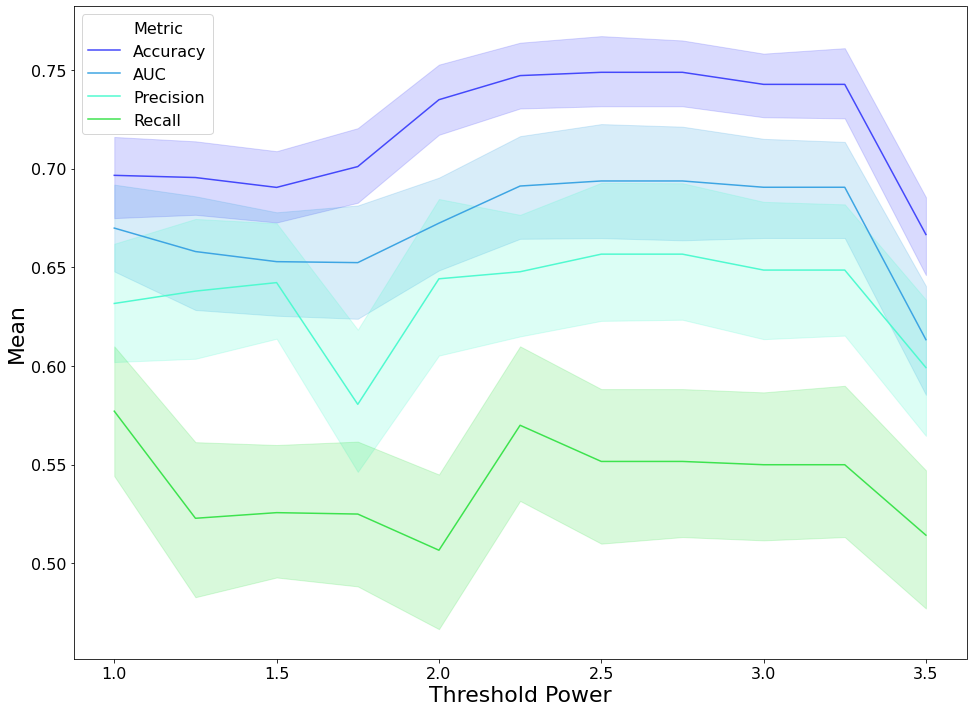

In [12]:
plt.rcParams.update({'font.size': 16})
total_metrics_df_melted = pd.melt(metrics_frame, id_vars=['Threshold Power', 'round'], value_vars=['Accuracy', 'AUC', 'Precision', 'Recall'],
                                  var_name='Metric', value_name='Mean')
# total_metrics_df_melted.head()
fig = plt.figure(figsize=(16,12))
ax = sns.lineplot(data=total_metrics_df_melted, x="Threshold Power", y="Mean", hue="Metric", palette=['#4448FB', '#3DA5E3', "#50FAD0", '#3DE34E'])

ax.set_ylabel('Mean', fontsize=22)
ax.set_xlabel('Threshold Power', fontsize=22)
# plt.savefig('Threshold_Power_Graph.svg', format='svg')
plt.show()